# Fig 1. Supplementary materials 

1. nAHD map from all obs datasets for WBGT28
2. nAHD map from all GCMs for WBGT28
3. horizontal latitude plots for both

To do:
- reporting figures, potentially also for WBGT30

To do elsewhere: 
- eval model v. obs doing shift fit in both
- eval/stability of different time periods for shift fit in obs (?) or goodness of fit in another way - ask Clair
  make sure i am using same present day year for all datasets : decide how to model covariates (do you used smooth or unsmoothed? and -GWI)
- potentially can include CI for nAHD and p0 but I think it gets messy... maybe not necessary


In [1]:
# necessary:  netcdf4-python, regionmask (automatically imports xarray), Cartopy, openpyxl,( statsmodels - do i need this ?)

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
%matplotlib inline

import xarray as xr
import geopandas as gpd
import regionmask as regionmask
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4
from scipy.stats import norm



In [2]:
from settings import *
from functions import * 
from plotscript import * # is there anything here im using?
 

In [3]:
start_message()

flags: {'models': 'ISIMIP3a', 'experiment': 'obsclim', 'metric': 'WBGT', 'method': 'shift_fit', 'time_method': None, 'shift_sigma': True, 'shift_period': (1901, 2019), 'shift_loglike': None, 'chunk_version': 0, 'var': 'wbgt'}
var: wbgt
VARs: None
indir_p: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/InputData/climate/atmosphere/bias-adjusted/global/daily/
indir_s: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/SecondaryInputData/climate/atmosphere/bias-adjusted/global/daily/
indir_obs: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/obsclim/global/daily/historical/
indir_counterclim: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/counterclim/global/daily/historical/
GCMs: ['CanESM5', 'CNRM-CM6-1', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0', 'EC-Earth3', 'UKESM1-0-LL', 'MPI-ESM1-2-HR', 'CNRM-ESM2-1']
datasets: ['GSWP3-W5E5', '20CRv3-ERA5', '20CRv3-W5E5']
lat_chunk: 90
lon_

In [4]:
# SETTINGS
figdir = os.path.join(figdirs, 'fig_feb25')

# plot settings
matplotlib.rc('axes',edgecolor='k')
fg_color = 'k' 

# geo information
landmask = get_mask()
cellarea = xr.open_dataarray(os.path.join(datadirs,'geo-information/clm45_area.nc4'))

days_in_month = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])

dir_shift_fit = 'forster2024-hitol-nan'


## Plotting functions

In [5]:
def plot_barplot_mean_lat(da_p1_lat, 
                          da_nAHD_lat,
                          ax,
                          isel_cols = None,
                          title = ' \n \n',
                          plot_ylabels=True,
                          bar_width = 0.1,
                          second_legend=True,
                          legend_anchor = (1, 1.15),
                          xlabel='Days per year'
                          ): # could also do lat processing in here ! 
    
    df_nAHD = da_nAHD_lat.to_pandas().T # or move this out of the fxn !! 
    df_p1 = da_p1_lat.to_pandas().T 

    if isel_cols: # maybe delete this ?? 
        df_nAHD = df_nAHD.iloc[:,[isel_cols]]
        df_p1 = df_p1.iloc[:,[isel_cols]]
    
    # Settings
    bar_width = bar_width
    index = df_nAHD.index.astype(str)
    index = [s.replace('(', '').replace(']', '').replace(',', '°,') + '°' for s in index]
    cmap = matplotlib.colormaps['tab10'] #plt.cm.get_cmap('tab10')
    colors = [cmap(i) for i in np.linspace(0, 1, 10)]
    columns = df_nAHD.columns

    # Plot each model side by side
    for i, column in enumerate(columns):
        ax.barh(np.arange(0, len(index)) - (i-len(columns)//2) * bar_width, df_nAHD[column], bar_width, label=column,color=colors[i])
        ax.barh(np.arange(0,len(index)) - (i-len(columns)//2) * bar_width, df_p1[column], bar_width,  color=colors[i],alpha=0.4) 
    ax.set_ylim(0,7.6)
    ax.set_xlim(0,200)

        
    # Set labels and title
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    if plot_ylabels:
        ax.set_yticks(np.arange(0, len(index)))  # Set the y-tick positions
        ax.set_yticklabels(index, rotation=0)
    else:
        ax.set_yticks(np.arange(0, len(index))) 
        ax.set_yticklabels([])

    
    lgd = ax.legend(fontsize=9,frameon=False, loc='upper right',handlelength=1.2,handletextpad=0.4,bbox_to_anchor=legend_anchor)
    if second_legend:
        tot_patch = mpatches.Patch(color=colors[0], label='days$_{tot}$',alpha=0.4,edgecolor=None)
        attr_patch = mpatches.Patch(color=colors[0], label='days$_{attr}$')
        ax.legend(handles = [tot_patch, attr_patch ], fontsize=9,frameon=False, loc='lower right',
                  handlelength=1.2,handletextpad=0.4,labelspacing = .1) 
        ax.add_artist(lgd)
        
    # Hide spines 
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)





In [6]:
def plot_map_nAHD(data_plot,
                    ax,
                    proj=ccrs.PlateCarree(),
                    vmin = -100,
                    vmax = 200, 
                    levels = np.linspace(-100, 200, 16),
                    title_label = None,
                  title=True,
                  cmap_skew=True,
                  cmap='RdBu_r'
            ):

    if cmap_skew:
        cmap = LinearSegmentedColormap.from_list('new_RdBu_r', plt.get_cmap('RdBu_r')(np.linspace(0.25, 1, 192))) 
        norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    crs = ccrs.PlateCarree()
    ax.set_extent([-179.75, 179.75, -60, 90], crs=ccrs.PlateCarree())

    # plot
    plot = data_plot.plot(vmin=vmin, vmax=vmax, cmap=cmap, transform=crs, levels=levels, extend='both', add_colorbar=False, ax=ax)
    ax.coastlines(color='black', linewidth=0.8)
    if title:
        try: 
            ax.set_title(f'{data_plot.dataset.values}')
        except:
            ax.set_title(f'{data_plot.model.values}')
    else:
        ax.set_title('')
            
    ax.set_title(title_label, loc='left',fontweight='bold')

    return plot 



## 1. nAHD (WBGT28) in reanalysis

To do:
- do some regional/focus area analysis, worst hit areas etc.
- check covariate value for present and GWI value (GHG=1.45 or anthro=1.29?) - or real time online 1.304 (i think this is anthro)

Notes:
- very similar to ATTRICI obsclim v. counterclim (see isimip3a-wbgt-obsclim-counterclim), same patterns but larger numbers here, bc ref periods are also shifted

In [7]:
# open data
flags['models']='ISIMIP3a'
dirname = 'output_shift-fit' 

da_list = []

for i in range(len(datasets)):
    dataset = datasets[i]
    filepath = glob.glob(os.path.join(outdirs, 
                                      f'output_shift-fit/{dir_shift_fit}/WBGT/ISIMIP3a/{dataset}/*_obsclim_WBGT_params_shift_loc_mon_1901_2019.nc'))[0]
    da = xr.open_dataarray(filepath).expand_dims("dataset").assign_coords(dataset=("dataset", [dataset]))
    da_list.append(da)
    da_params = xr.concat(da_list, dim="dataset")
    

In [8]:
gmst_smo = get_gmst_smo(ntime=4, observed_warming_path=observed_warming_path_annual)
gmst_smo

,gmst
year,
1850,-0.050939
1851,0.034209
1852,0.071770
1853,0.067307
1854,0.058773
...,...
2019,1.210821
2020,1.209226
2021,1.160743


In [9]:
threshold = 28

da_nAHD_obs, da_nAHD_mo, da_p0, da_p1 = calc_nAHD_shift_fit(da_params, threshold, gmst_smo,year_pres=2023,GWI=1.3)

In [10]:
days_in_month_da = xr.DataArray(days_in_month, dims=['month'], coords={'month': da_p1['month']})
da_p1_obs = (da_p1 * days_in_month_da).sum(dim='month')


## 2. Zonal area-weighted average

Notes:
- obs generally agree on nAHD but don't agree on total n of days crossing threshold today? w5e5 is much more. why is nAHD so similar?
  
Extra:
+ add cities inset where super high (somewhere in India, somewhere in Indonesia, somewhere in S.America / Africa... Or in SI / conceptual figure ! with threshold and p1/p0 etc

In [11]:
# Define the latitudinal bands
lat_bins = range(-90, 91, 20)
[i for i in lat_bins]

[-90, -70, -50, -30, -10, 10, 30, 50, 70, 90]

In [12]:
days_in_month_da = xr.DataArray(days_in_month, coords=[da_p1['month']], dims='month')
weighted_sum = (da_p1 * landmask * days_in_month_da * cellarea).groupby_bins('lat', lat_bins[1:]).sum(dim=['lat','lon','month']) 
total_area = (cellarea * landmask).groupby_bins('lat', lat_bins[1:]).sum(dim=['lat','lon'])

da_p1_mean_lat = weighted_sum / total_area 
#da_p1_mean_lat.to_pandas().T.round(2)

In [13]:
weighted_sum = (da_nAHD_obs * landmask * cellarea).groupby_bins('lat', lat_bins[1:]).sum(dim=['lat','lon']) 
total_area = (cellarea * landmask).groupby_bins('lat', lat_bins[1:]).sum(dim=['lat','lon'])

da_nAHD_mean_lat = weighted_sum / total_area 
da_nAHD_mean_lat.to_pandas().T.round(2)

dataset,GSWP3-W5E5,20CRv3-ERA5,20CRv3-W5E5
lat_bins,,,
"(-70, -50]",-0.00,0.00,0.00
"(-50, -30]",-0.18,0.96,1.52
"(-30, -10]",5.94,5.80,6.28
"(-10, 10]",41.02,29.99,58.03
"(10, 30]",25.03,19.04,21.82
"(30, 50]",2.32,1.02,1.19
"(50, 70]",0.08,0.04,0.04
"(70, 90]",0.01,-0.00,-0.00


### Plot reanalysis

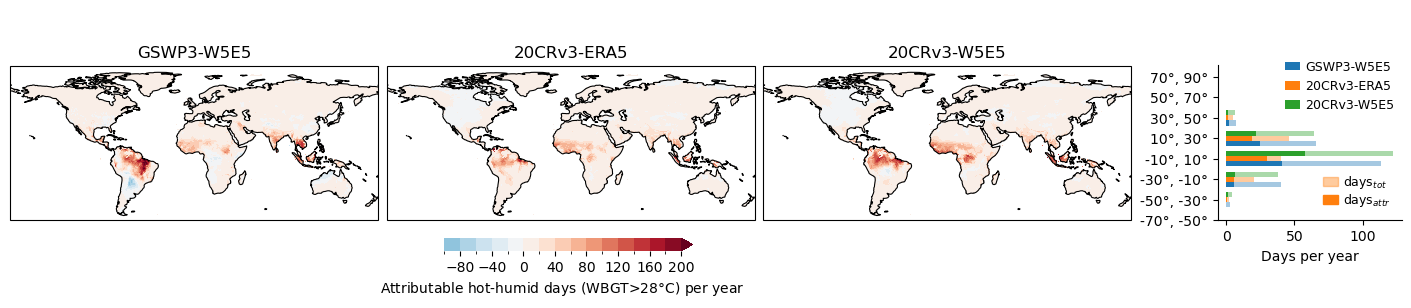

In [14]:

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches


# settings 
proj = ccrs.PlateCarree() #ccrs.Robinson()
crs = ccrs.PlateCarree()

# cmap
cmap = plt.get_cmap('RdBu_r')
cmap_data = cmap(np.linspace(0, 1, 256))
new_cmap_data = cmap_data[64:]  # This excludes the first quarter (64/256)
new_cmap = LinearSegmentedColormap.from_list('new_RdBu_r', new_cmap_data)

# Define the normalization boundaries
vmin, vmax = -100, 200
levels = np.linspace(vmin, vmax, 16)
norm = BoundaryNorm(levels, ncolors=new_cmap.N, clip=True)




# create figure layout
fig = plt.figure(figsize=(14, 3), layout='constrained')  
gs = gridspec.GridSpec(1, 4, width_ratios=[2,2,2,1],figure=fig)  

# plot observational nAHD 
axes = [0,0,0,0]
for i in range(3):
    data_plot = da_nAHD_obs.isel(dataset=i) * landmask  # include or not landmask ?? 
    axes[i]= fig.add_subplot(gs[0, i], projection= proj)  
    ax=axes[i]
    ax.set_extent([-181, 181, -60, 90], crs=ccrs.PlateCarree())
    plot = data_plot.plot(vmax=vmax, vmin=vmin, cmap=new_cmap,  transform=crs, levels=levels, extend='both', add_colorbar=False, ax=ax) #norm=norm,
    ax.coastlines(color='black', linewidth=0.8)
    ax.set_title(f'{data_plot.dataset.values}', color=fg_color)
    #ax.gridlines(draw_labels=False)


# colorbar 
cbar_lab = 'Attributable hot-humid days (WBGT>28$\degree$C) per year'
cbar = fig.colorbar(plot, extend='max', ax=axes[0:3], location='bottom',shrink=0.3, fraction=0.08, pad=-0.15)
cbar.set_label(label=cbar_lab, color=fg_color)
cbar.ax.xaxis.set_tick_params(which='both', color=fg_color, labelcolor=fg_color)
cbar.outline.set_edgecolor('none')



ax= fig.add_subplot(gs[0, 3])  

# Convert xarray DataArray to a pandas DataFrame 
df_nAHD = da_nAHD_mean_lat.to_pandas().T#.iloc
df_p1 = da_p1_mean_lat.to_pandas().T#.iloc
# Settings
bar_width = 0.25
index = df_p1.index.astype(str)
index = [s.replace('(', '').replace(']', '').replace(',', '°,') + '°' for s in index]
columns = df_p1.columns
cmap = matplotlib.colormaps['tab10'] #plt.cm.get_cmap('tab10')
colors = [cmap(i) for i in np.linspace(0, 1, 10)]
# Plot each column side by side
for i, column in enumerate(columns):
    ax.barh(np.arange(0,len(index)) + (i-1) * bar_width, df_nAHD[column], bar_width, label=column,color=colors[i])
    ax.barh(np.arange(0,len(index)) + (i-1) * bar_width, df_p1[column], bar_width,  color=colors[i],alpha=0.4) 
ax.set_ylim(0,7.6) # match latitudes

    
# Set labels and title
ax.set_xlabel('Days per year')
ax.set_title(' \n \n')
plt.yticks(ticks=np.arange(0,len(index)), labels=index, rotation=0)
# add two legends
lgd = ax.legend(fontsize=9,frameon=False, loc='upper right',handlelength=1.2,handletextpad=0.4,bbox_to_anchor=(1.02, 1.1))
tot_patch = mpatches.Patch(color=colors[1], label='days$_{tot}$',alpha=0.4,edgecolor=None)
attr_patch = mpatches.Patch(color=colors[1], label='days$_{attr}$')
ax.legend(handles = [tot_patch, attr_patch ], fontsize=9,frameon=False, loc='lower right',handlelength=1.2,handletextpad=0.4,labelspacing = .1) 
ax.add_artist(lgd)
# Hide spines 
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)


In [15]:
print('min, max, mean (over land, not area-weighted)')

for i in range(3):
    data = da_nAHD_obs.isel(dataset=i) * landmask 
    print(data.dataset.values, data.min().values, data.max().values, data.mean().values)


min, max, mean (over land, not area-weighted)
GSWP3-W5E5 -88.38899316463832 289.9744061757094 9.19715841990313
20CRv3-ERA5 -15.083441447330005 221.50140154032442 6.882482146402155
20CRv3-W5E5 -39.470813709731374 213.5021554995893 10.448494795778032


## 3. Climate models 

Extra
- plot diff nAHD models-obs make a new eval figure/plot

In [16]:
dirname='output_empirical'
models='ISIMIP3b'

year=2023

da_nAHD_models = open_all_nAHD(GCMs,  metric='WBGT28', outdirname=dirname, year_pres=year) # see here i coded what models it is in the fxn 
empty, da_p1_models = open_all_p0_p1(GCMs, metric='WBGT28', outdirname=dirname, year_pres=year)

In [17]:
weighted_sum = (da_nAHD_models * landmask * cellarea).groupby_bins('lat', lat_bins[1:]).sum(dim=['lat','lon']) 
total_area = (cellarea * landmask).groupby_bins('lat', lat_bins[1:]).sum(dim=['lat','lon'])

da_nAHD_mean_lat_models = weighted_sum / total_area 
#da_nAHD_mean_lat_models.to_pandas().T

In [18]:
weighted_sum = (da_p1_models * 365 * landmask * cellarea).groupby_bins('lat', lat_bins[1:]).sum(dim=['lat','lon']) 
total_area = (cellarea * landmask).groupby_bins('lat', lat_bins[1:]).sum(dim=['lat','lon'])

da_p1_mean_lat_models = weighted_sum / total_area 
#da_p1_mean_lat_models.to_pandas().T

## 4. Plots 

### map nAHD (Fig SI.1) 

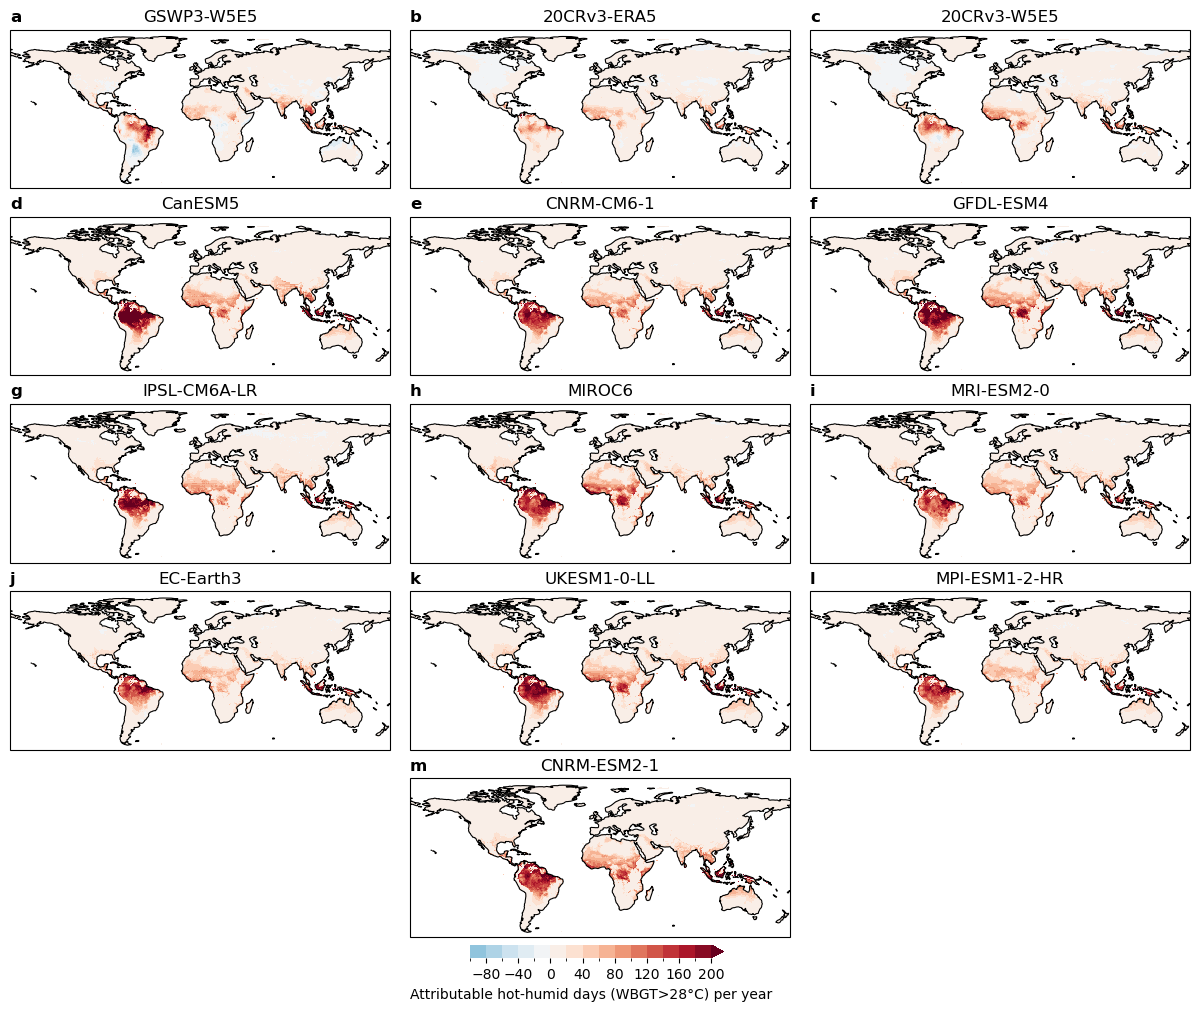

In [19]:
import string

# Settings
proj = crs = ccrs.PlateCarree()
cmap = LinearSegmentedColormap.from_list('new_RdBu_r', plt.get_cmap('RdBu_r')(np.linspace(0.25, 1, 192))) 
vmin, vmax, levels = -100, 200, np.linspace(-100, 200, 16)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
titles = [f"{letter}" for letter in string.ascii_lowercase[:13]]

# Create figure layout
fig = plt.figure(figsize=(12,10), layout='constrained')
gs = gridspec.GridSpec(5, 6, figure=fig)

# Plot observed data
for j in range(3):
    ax = fig.add_subplot(gs[0, j*2:j*2+2], projection=proj)
    data_plot = da_nAHD_obs.isel(dataset=j) * landmask
    plot_map_nAHD(data_plot,
                  ax,
                  title_label=titles[j],)

# Plot model data
for i in range(1, 5):
    for j in range(3):
        if (i-1)*3 + j > 8: break
        ax = fig.add_subplot(gs[i, j*2:j*2+2], projection=proj)
        data_plot = da_nAHD_models.isel(model=(i-1)*3+j) * landmask
        plot_map_nAHD(data_plot,
                  ax,
                  title_label=titles[3 + (i-1)*3 + j],)

# Extra model subplot
ax = fig.add_subplot(gs[4, 2:4], projection=proj)
data_plot = da_nAHD_models.isel(model=9) * landmask
plot_map_nAHD(data_plot,
                  ax,
                  title_label=titles[-1],)

# Colorbar
cbar = fig.colorbar(plot, extend='max', ax=ax, location='bottom', shrink=1, fraction=0.08)
cbar.set_label('Attributable hot-humid days (WBGT>28°C) per year', )
cbar.outline.set_edgecolor('none')


#plt.savefig(os.path.join(figdir,'fig1_SI_maps.pdf'),dpi=300,transparent=True)
#plt.savefig(os.path.join(figdir,'fig1_SI_maps.png'),dpi=300,transparent=True)


### Zonal average (Fig SI.3)

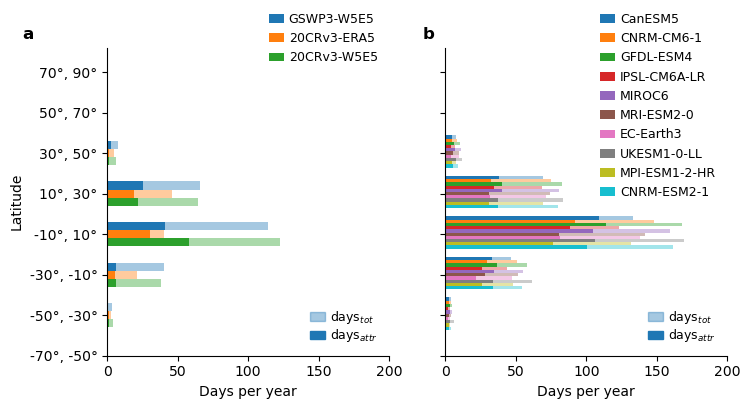

In [20]:

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4)) # try 7,3 for smaller

# Bar plot obs
plot_barplot_mean_lat(da_p1_mean_lat, 
                          da_nAHD_mean_lat,
                          ax=ax1,
                          second_legend=True,
                            plot_ylabels=True,
                          bar_width = 0.2,
                      title='\n',
                      #xlabel='Hot-humid days (WBGT>28°C) per year'
                     )
ax1.set_title('a',loc='left',fontweight='bold',x=-.3)
ax1.set_ylabel('Latitude')

# Bar plot models 
ax2.sharex(ax1)
plot_barplot_mean_lat(da_p1_mean_lat_models, 
                          da_nAHD_mean_lat_models,
                          ax=ax2,
                         plot_ylabels=False,
                         bar_width = 0.08,
                     title='\n',)
ax2.set_title('b',loc='left',fontweight='bold',x=-.08);


plt.savefig(os.path.join(figdir,'fig1_SI_barplot.pdf'),dpi=300,transparent=True)
plt.savefig(os.path.join(figdir,'fig1_SI_barplot.png'),dpi=300,transparent=True)


In [21]:
da_nAHD_mean_lat.to_pandas().T.round(2)

dataset,GSWP3-W5E5,20CRv3-ERA5,20CRv3-W5E5
lat_bins,,,
"(-70, -50]",-0.00,0.00,0.00
"(-50, -30]",-0.18,0.96,1.52
"(-30, -10]",5.94,5.80,6.28
"(-10, 10]",41.02,29.99,58.03
"(10, 30]",25.03,19.04,21.82
"(30, 50]",2.32,1.02,1.19
"(50, 70]",0.08,0.04,0.04
"(70, 90]",0.01,-0.00,-0.00


In [22]:
da_p1_mean_lat.to_pandas().T.round(2)

dataset,GSWP3-W5E5,20CRv3-ERA5,20CRv3-W5E5
lat_bins,,,
"(-70, -50]",0.00,0.00,0.00
"(-50, -30]",3.02,2.37,3.97
"(-30, -10]",40.11,20.78,38.24
"(-10, 10]",113.84,40.26,122.53
"(10, 30]",65.76,46.01,64.50
"(30, 50]",7.27,4.82,6.53
"(50, 70]",0.14,0.10,0.11
"(70, 90]",0.01,0.00,0.01


### Total HD (Fig SI.2)

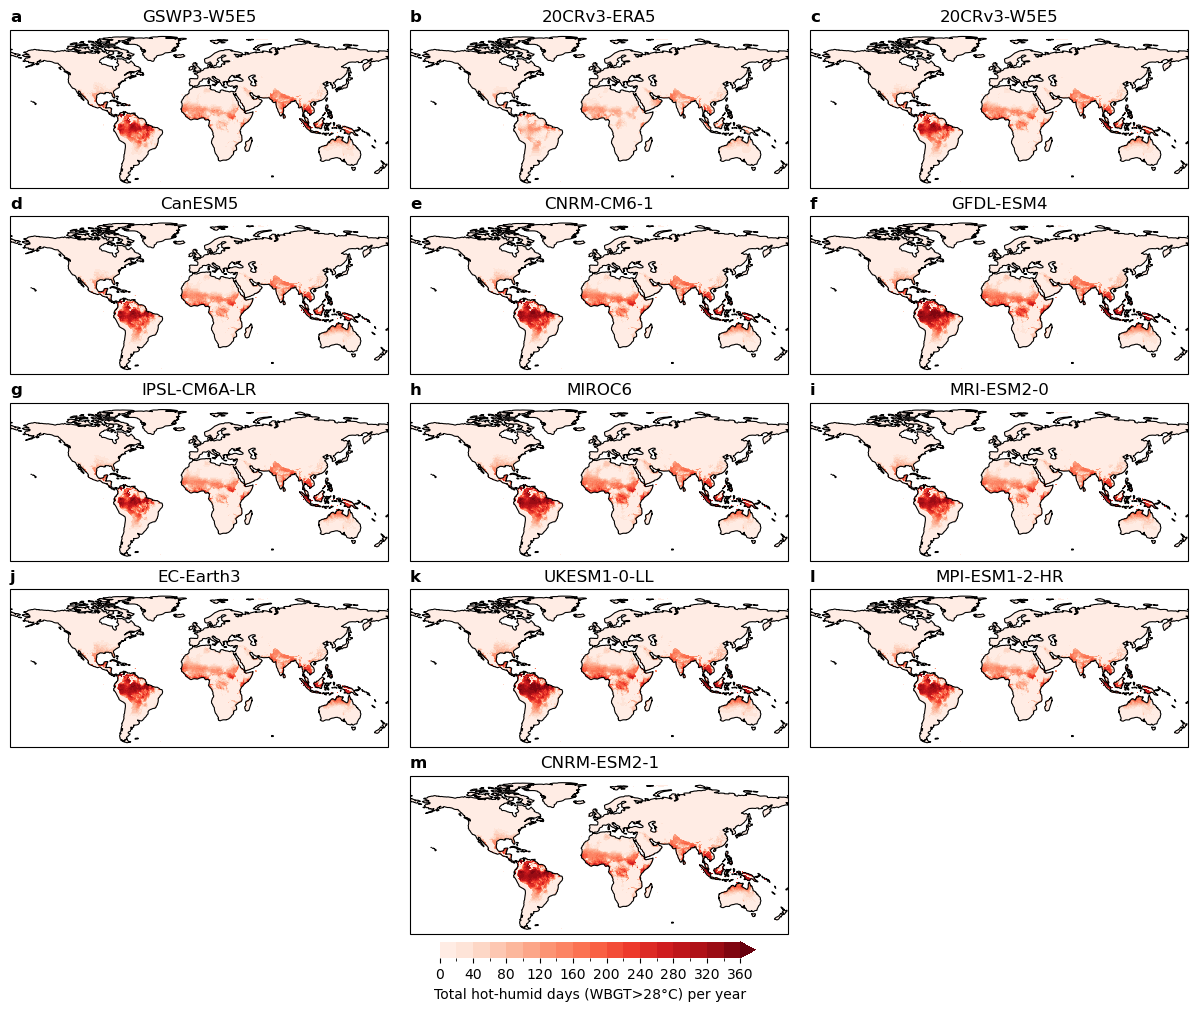

In [23]:
import string

# Settings
proj = crs = ccrs.PlateCarree()
cmap = 'Reds'
vmin, vmax,  = 0, 360 
levels=np.linspace(vmin,vmax, 19)
titles = [f"{letter}" for letter in string.ascii_lowercase[:13]]

# Create figure layout
fig = plt.figure(figsize=(12,10), layout='constrained')
gs = gridspec.GridSpec(5, 6, figure=fig)

# Plot observed data
for j in range(3):
    ax = fig.add_subplot(gs[0, j*2:j*2+2], projection=proj)
    data_plot = da_p1_obs.isel(dataset=j) * landmask
    plot = plot_map_nAHD(data_plot,
                         ax,
                         title_label=titles[j],
                         vmin=vmin, vmax=vmax, levels=levels,
                         cmap_skew=False,
                         cmap='Reds')

# Plot model data
for i in range(1, 5):
    for j in range(3):
        if (i-1)*3 + j > 8: break
        ax = fig.add_subplot(gs[i, j*2:j*2+2], projection=proj)
        data_plot = (da_p1_models*365).isel(model=(i-1)*3+j) * landmask
        plot_map_nAHD(data_plot,
                      ax,
                      title_label=titles[3 + (i-1)*3 + j],
                      vmin=vmin, vmax=vmax, levels=levels,
                      cmap_skew=False,
                      cmap='Reds')
# Extra model subplot
ax = fig.add_subplot(gs[4, 2:4], projection=proj)
data_plot = (da_p1_models*365).isel(model=9) * landmask
plot_map_nAHD(data_plot,
              ax,
              title_label=titles[-1],
              vmin=vmin, vmax=vmax, levels=levels,
              cmap_skew=False,
              cmap='Reds')
# Colorbar
cbar = fig.colorbar(plot, extend='max', ax=ax, location='bottom', shrink=1, fraction=0.1)
cbar.set_label('Total hot-humid days (WBGT>28°C) per year', )
cbar.outline.set_edgecolor('none')


#plt.savefig(os.path.join(figdir,'fig1_SI_maps_totaldays.pdf'),dpi=300,transparent=True)
#plt.savefig(os.path.join(figdir,'fig1_SI_maps_totaldays.png'),dpi=300,transparent=True)


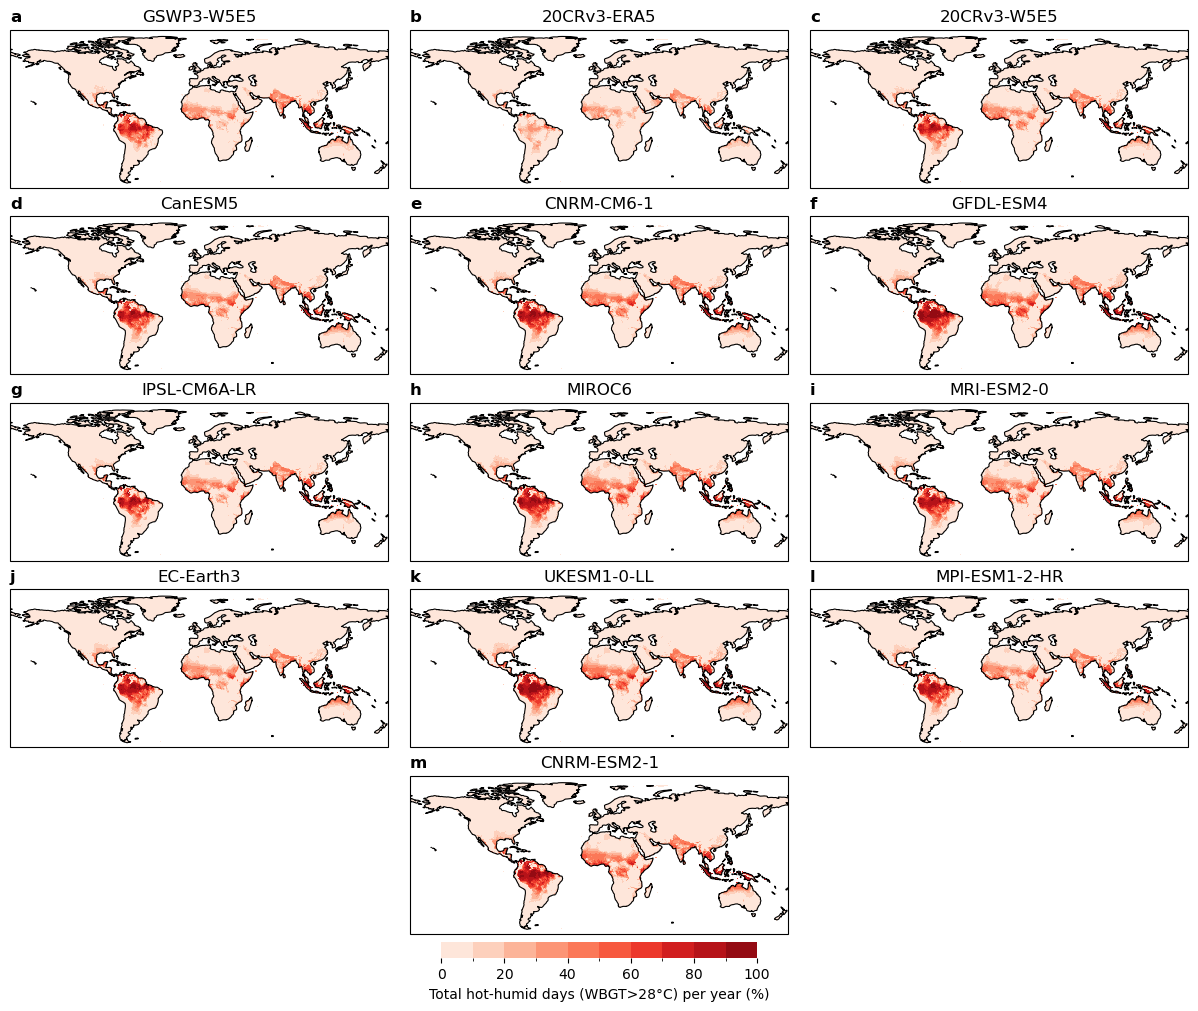

In [24]:

# Settings
proj = crs = ccrs.PlateCarree()
cmap = 'eds'
vmin, vmax,  = 0, 100 
levels=np.linspace(vmin,vmax, 11)
titles = [f"{letter}" for letter in string.ascii_lowercase[:13]]

# Create figure layout
fig = plt.figure(figsize=(12,10), layout='constrained')
gs = gridspec.GridSpec(5, 6, figure=fig)

# Plot observed data
for j in range(3):
    ax = fig.add_subplot(gs[0, j*2:j*2+2], projection=proj)
    data_plot = ((da_p1_obs/365)*100).isel(dataset=j) * landmask
    plot = plot_map_nAHD(data_plot,
                         ax,
                         title_label=titles[j],
                         vmin=vmin, vmax=vmax, levels=levels,
                         cmap_skew=False,
                         cmap='Reds')

# Plot model data
for i in range(1, 5):
    for j in range(3):
        if (i-1)*3 + j > 8: break
        ax = fig.add_subplot(gs[i, j*2:j*2+2], projection=proj)
        data_plot = (da_p1_models*100).isel(model=(i-1)*3+j) * landmask
        plot_map_nAHD(data_plot,
                      ax,
                      title_label=titles[3 + (i-1)*3 + j],
                      vmin=vmin, vmax=vmax, levels=levels,
                      cmap_skew=False,
                      cmap='Reds')
# Extra model subplot
ax = fig.add_subplot(gs[4, 2:4], projection=proj)
data_plot = (da_p1_models*100).isel(model=9) * landmask
plot_map_nAHD(data_plot,
              ax,
              title_label=titles[-1],
              vmin=vmin, vmax=vmax, levels=levels,
              cmap_skew=False,
              cmap='Reds')
# Colorbar
cbar = fig.colorbar(plot,  ax=ax, extend='neither', location='bottom', shrink=1, fraction=0.1)
cbar.set_label('Total hot-humid days (WBGT>28°C) per year (%)', )
cbar.outline.set_edgecolor('none')


#plt.savefig(os.path.join(figdir,'fig1_SI_maps.pdf'),dpi=300,transparent=True)
#plt.savefig(os.path.join(figdir,'fig1_SI_maps.png'),dpi=300,transparent=True)


## 5. Reporting numbers

In [25]:
def reporting_summary(df, args, axis=1):
    summary = {arg: getattr(df, arg)(axis=axis) for arg in args}
    
    # Concatenate results along columns
    df_summary = pd.concat(summary, axis=1)
    
    return df_summary.round(2)

In [26]:
# nAHD reanalysis

df = da_nAHD_mean_lat.to_pandas().T 
reporting_summary(df, ['median', 'min', 'max' ])

,median,min,max
lat_bins,,,
"(-70, -50]",0.00,-0.00,0.00
"(-50, -30]",0.96,-0.18,1.52
"(-30, -10]",5.94,5.80,6.28
"(-10, 10]",41.02,29.99,58.03
"(10, 30]",21.82,19.04,25.03
"(30, 50]",1.19,1.02,2.32
"(50, 70]",0.04,0.04,0.08
"(70, 90]",-0.00,-0.00,0.01


In [27]:
# nAHD models

df = da_nAHD_mean_lat_models.to_pandas().T
reporting_summary(df, ['median', 'min', 'max'])

,median,min,max
lat_bins,,,
"(-70, -50]",0.00,0.00,0.00
"(-50, -30]",2.70,1.65,3.54
"(-30, -10]",31.29,21.83,36.66
"(-10, 10]",96.33,76.02,114.06
"(10, 30]",35.68,30.90,39.96
"(30, 50]",5.01,4.09,7.17
"(50, 70]",0.06,0.03,0.34
"(70, 90]",0.00,0.00,0.03


In [28]:
df = da_p1_mean_lat.to_pandas().T
reporting_summary(df, ['median', 'min', 'max'])

,median,min,max
lat_bins,,,
"(-70, -50]",0.00,0.00,0.00
"(-50, -30]",3.02,2.37,3.97
"(-30, -10]",38.24,20.78,40.11
"(-10, 10]",113.84,40.26,122.53
"(10, 30]",64.50,46.01,65.76
"(30, 50]",6.53,4.82,7.27
"(50, 70]",0.11,0.10,0.14
"(70, 90]",0.01,0.00,0.01


In [29]:
df = da_p1_mean_lat_models.to_pandas().T
reporting_summary(df, ['median', 'min', 'max'])

,median,min,max
lat_bins,,,
"(-70, -50]",0.00,0.00,0.00
"(-50, -30]",3.88,2.89,5.99
"(-30, -10]",51.16,43.32,61.39
"(-10, 10]",144.73,123.23,169.59
"(10, 30]",74.77,68.71,83.63
"(30, 50]",9.16,7.09,12.03
"(50, 70]",0.08,0.04,0.36
"(70, 90]",0.00,0.00,0.03


## 6. Numbers for WBGT30

For comparison

To do:
- see also other metrics for comparison if more similar obs/models in terms of zonal averages

In [30]:
threshold = 30
da_nAHD_obs_30, da_nAHD_mo_30, da_p0_30, da_p1_30 = calc_nAHD_shift_fit(da_params, threshold, gmst_smo,year_pres=2023,GWI=1.3)

weighted_sum = (da_nAHD_obs_30 * landmask * cellarea).groupby_bins('lat', lat_bins[1:]).sum(dim=['lat','lon']) 
total_area = (cellarea * landmask).groupby_bins('lat', lat_bins[1:]).sum(dim=['lat','lon'])

da_nAHD_mean_lat_30 = weighted_sum / total_area 
df = da_nAHD_mean_lat_30.to_pandas().T.round(2)

reporting_summary(df, ['median', 'min', 'max'])

,median,min,max
lat_bins,,,
"(-70, -50]",0.00,0.00,0.00
"(-50, -30]",0.21,-0.05,0.37
"(-30, -10]",1.13,-0.32,1.82
"(-10, 10]",8.26,1.24,10.64
"(10, 30]",9.13,5.25,10.47
"(30, 50]",0.42,0.27,0.44
"(50, 70]",0.01,0.01,0.02
"(70, 90]",-0.00,-0.00,-0.00


In [31]:
dirname='output_empirical'
models='ISIMIP3b'

year=2023

da_nAHD_models_30 = open_all_nAHD(GCMs,  metric='WBGT30', outdirname=dirname, year_pres=year) # see here i coded what models it is in the fxn 
empty, da_p1_models_30 = open_all_p0_p1(GCMs, metric='WBGT30', outdirname=dirname, year_pres=year)

weighted_sum = (da_nAHD_models_30 * landmask * cellarea).groupby_bins('lat', lat_bins[1:]).sum(dim=['lat','lon']) 
total_area = (cellarea * landmask).groupby_bins('lat', lat_bins[1:]).sum(dim=['lat','lon'])

da_nAHD_mean_lat_models_30 = weighted_sum / total_area 
df = da_nAHD_mean_lat_models_30.to_pandas().T

reporting_summary(df, ['median', 'min', 'max'])

,median,min,max
lat_bins,,,
"(-70, -50]",0.00,0.00,0.00
"(-50, -30]",0.41,0.19,0.71
"(-30, -10]",9.68,5.68,14.57
"(-10, 10]",18.01,9.08,33.33
"(10, 30]",15.64,11.10,20.31
"(30, 50]",1.40,0.96,2.45
"(50, 70]",0.00,0.00,0.04
"(70, 90]",0.00,0.00,0.01
